<a href="https://colab.research.google.com/github/psaw/hse-ai24-ml/blob/main/Chocolate_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Прогнозирование рейтинга шоколада.

## Постановка задачи

В датасете содержится информация о более чем 1700 шоколадках. В датасете представлена информация о темном шоколаде.

Система рейтинга шоколада:
5 = Elite
4 = Premium
3 = Satisfactory(3.0) to praiseworthy(3.75)
2 = Disappointing
1 = Unpleasant

Для получения рейтинга каждой шоколадки оцениваются все ее характеристики.

**Задача** - по характеристикам шоколадки научиться предсказывать ее рейтинг без округлений (то есть если рейтинг 3.75 - хорошая модель должна предсказать 3.75).

Рейтинги были собраны Brady Brelinski, Founding Member of the Manhattan Chocolate Society.

## Решение
Автор решения: Юрий Конов, ИИ24
Kaggle: yuryko


## Импорт библиотек, загрузка данных

In [1]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings

In [2]:
%pip install catboost -q
%pip install association_metrics -q
%pip install category_encoders -q
%pip install optuna -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
TRAIN = "https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/chocolate_train.csv"
TEST = "https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/chocolate_test_new.csv"

In [4]:
train_df = pd.read_csv(TRAIN)

## Обзор данных, подготовка к обучению

In [5]:
train_df.head()

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,457,2009,72%,U.K.,3.25,Trinitario,Venezuela
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72%,Switzerland,3.50,,Venezuela
2,Dark Forest,Tanzania,1554,2015,70%,U.S.A.,3.00,,Tanzania
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72%,U.S.A.,3.00,Trinitario,Dominican Republic
4,Pralus,"Java, Indonesie",32,2006,75%,France,3.50,Criollo,Indonesia


Удаляем все строки с пропусками

In [6]:
train_df.dropna(axis=0, inplace=True)

Выделяем матрицу объект-признак и вектор с целевой переменной

In [7]:
X = train_df # .drop('Rating', axis=1)
y = train_df['Rating']

## Преобразование данных

In [8]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1253 entries, 0 to 1254
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Company               1253 non-null   object 
 1   Specific Bean Origin  1253 non-null   object 
 2   REF                   1253 non-null   int64  
 3   Review                1253 non-null   int64  
 4   Cocoa Percent         1253 non-null   object 
 5   Company Location      1253 non-null   object 
 6   Rating                1253 non-null   float64
 7   Bean Type             1253 non-null   object 
 8   Broad Bean Origin     1253 non-null   object 
dtypes: float64(1), int64(2), object(6)
memory usage: 97.9+ KB


In [9]:
def cocoa_percent_transformer(X):
    X['Cocoa Percent_numeric'] = X['Cocoa Percent'].str.rstrip('%').astype(float)
    return X


def split_and_replace(X, column_name, separator, replace_value):
    X[column_name+'_cat'] = X[column_name].str.split(separator, expand=True)[0].replace(replace_value, np.nan)
    return X


def clean_df(df):
    _df = cocoa_percent_transformer(df)
    print("1: ", _df.shape)
    _df = split_and_replace(_df, 'Broad Bean Origin', ',', '\xa0')
    print("2: ", _df.shape)
    _df = split_and_replace(_df, 'Specific Bean Origin', ',', '\xa0')
    print("3: ", _df.shape)
    _df = split_and_replace(_df, 'Bean Type', r'[ ,(]', '\xa0')
    print("4: ", _df.shape)
    # Объединение с оригинальными данными, за исключением удаляемых столбцов
    _df = _df.drop(['REF', 'Cocoa Percent', 'Bean Type', 'Broad Bean Origin', 'Specific Bean Origin'], axis=1)
    print("5: ", _df.shape)
    return _df

print("in: ", X.shape)
X_new = clean_df(X.copy())
print("out: ", X_new.shape)
X_new

in:  (1253, 9)
1:  (1253, 10)
2:  (1253, 11)
3:  (1253, 12)
4:  (1253, 13)
5:  (1253, 8)
out:  (1253, 8)


,Company,Review,Company Location,Rating,Cocoa Percent_numeric,Broad Bean Origin_cat,Specific Bean Origin_cat,Bean Type_cat
0,Willie's Cacao,2009,U.K.,3.25,72.0,Venezuela,Rio Caribe,Trinitario
1,Beschle (Felchlin),2010,Switzerland,3.50,72.0,Venezuela,Ocumare,NaN
2,Dark Forest,2015,U.S.A.,3.00,70.0,Tanzania,Tanzania,NaN
3,Brasstown aka It's Chocolate,2013,U.S.A.,3.00,72.0,Dominican Republic,Cooproagro,Trinitario
4,Pralus,2006,France,3.50,75.0,Indonesia,Java,Criollo
...,...,...,...,...,...,...,...,...
1250,Artisan du Chocolat,2009,U.K.,3.00,80.0,Madagascar,Madagascar,Criollo
1251,Marana,2016,Peru,2.75,70.0,Peru,Cusco,NaN
1252,Arete,2015,U.S.A.,3.50,68.0,Peru,Nacional,Forastero
1253,Fresco,2011,U.S.A.,3.50,72.0,Dominican Republic,Conacado,NaN


#### Биннирование признака `Cocoa Percent_numeric`

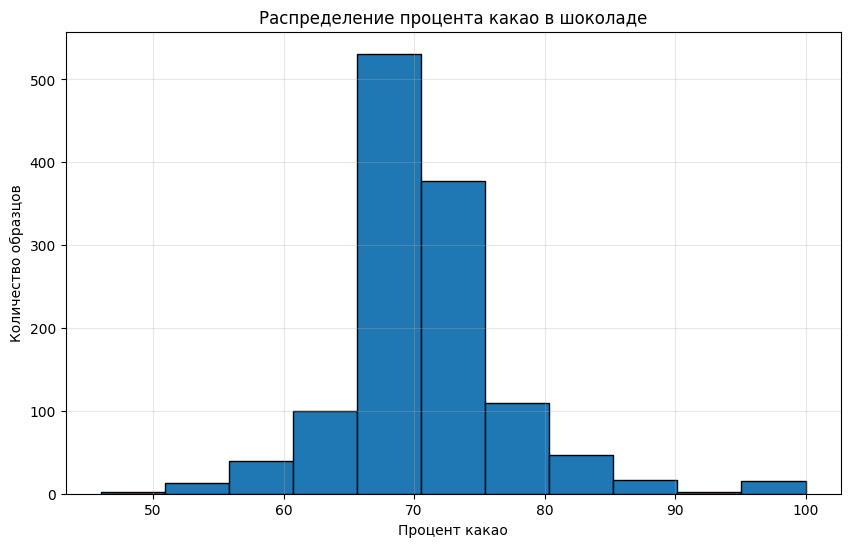

In [10]:
plt.figure(figsize=(10, 6))
plt.hist(X_new['Cocoa Percent_numeric'], bins=11, edgecolor='black')
plt.title('Распределение процента какао в шоколаде')
plt.xlabel('Процент какао')
plt.ylabel('Количество образцов')
plt.grid(True, alpha=0.3)
plt.show()


In [11]:
from sklearn.preprocessing import KBinsDiscretizer

discretizer = KBinsDiscretizer(n_bins=11, encode='ordinal', strategy='kmeans', random_state=42)
discretizer.fit(X_new[['Cocoa Percent_numeric']])
X_new['Cocoa Percent_numeric_binned'] = discretizer.transform(X_new[['Cocoa Percent_numeric']])


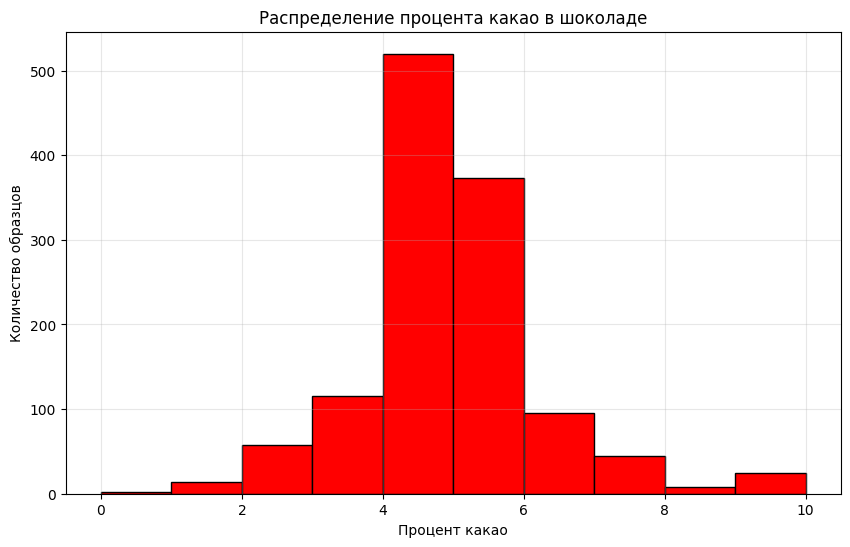

In [12]:
plt.figure(figsize=(10, 6))
plt.hist(X_new['Cocoa Percent_numeric_binned'], color='red', edgecolor='black')
plt.title('Распределение процента какао в шоколаде')
plt.xlabel('Процент какао')
plt.ylabel('Количество образцов')
plt.grid(True, alpha=0.3)
plt.show()


In [13]:
X_new['Cocoa Percent_numeric_binned'].value_counts()

Cocoa Percent_numeric_binned
4.0     520
5.0     373
3.0     115
6.0      95
2.0      57
7.0      44
10.0     15
1.0      14
9.0      10
8.0       8
0.0       2
Name: count, dtype: int64

#### Корреляция признаков

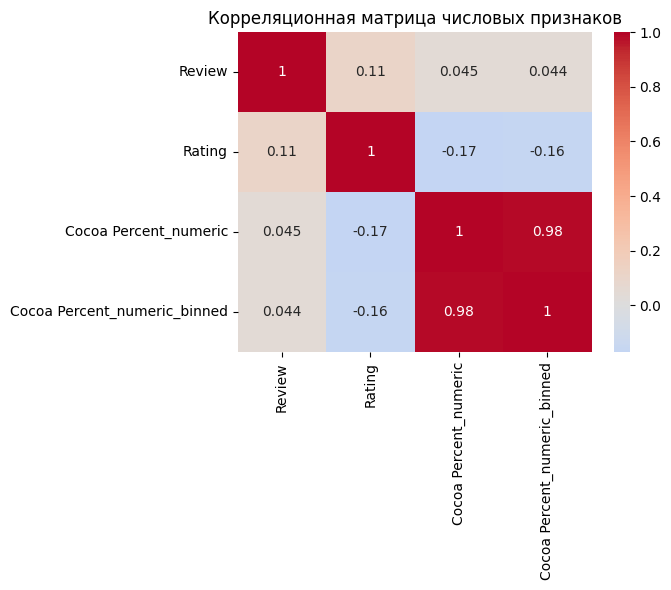

In [14]:
plt.figure(figsize=(7, 6))
correlation_matrix = X_new.select_dtypes(include=['float64', 'int64']).corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Корреляционная матрица числовых признаков')
plt.tight_layout()
plt.show()


Ничего интересного.  
Признак `Cocoa Percent_numeric` удалим позже. 

In [15]:
X_new.describe(include='object')

,Company,Company Location,Broad Bean Origin_cat,Specific Bean Origin_cat,Bean Type_cat
count,1253,1253,1198,1253,625
unique,376,58,66,529,9
top,Soma,U.S.A.,Venezuela,Madagascar,Trinitario
freq,34,520,148,46,293


In [16]:
import association_metrics as am
warnings.filterwarnings('ignore')

XC = X_new.apply(
        lambda x: x.astype("category") if x.dtype == "object" else x)

cramersv = am.CramersV(XC)

cramersv.fit()

,Company,Company Location,Broad Bean Origin_cat,Specific Bean Origin_cat,Bean Type_cat
Company,1.000000,0.999651,0.633931,0.653217,0.816914
Company Location,0.999651,1.000000,0.378944,0.735872,0.268613
Broad Bean Origin_cat,0.633931,0.378944,1.000000,0.976352,0.506266
Specific Bean Origin_cat,0.653217,0.735872,0.976352,1.000000,0.871187
Bean Type_cat,0.816914,0.268613,0.506266,0.871187,1.000000


`Broad Bean Origin_cat` и `Specific Bean Origin_cat` сильно связаны.  
Удалим `Broad Bean Origin_cat`, т.к. в нем есть пропуски

In [17]:
X_new.drop('Broad Bean Origin_cat', axis=1, inplace=True)

#### Визуализируем зависимость целевой переменной от категориальных
(перебрал все категории, ничего не увидел)

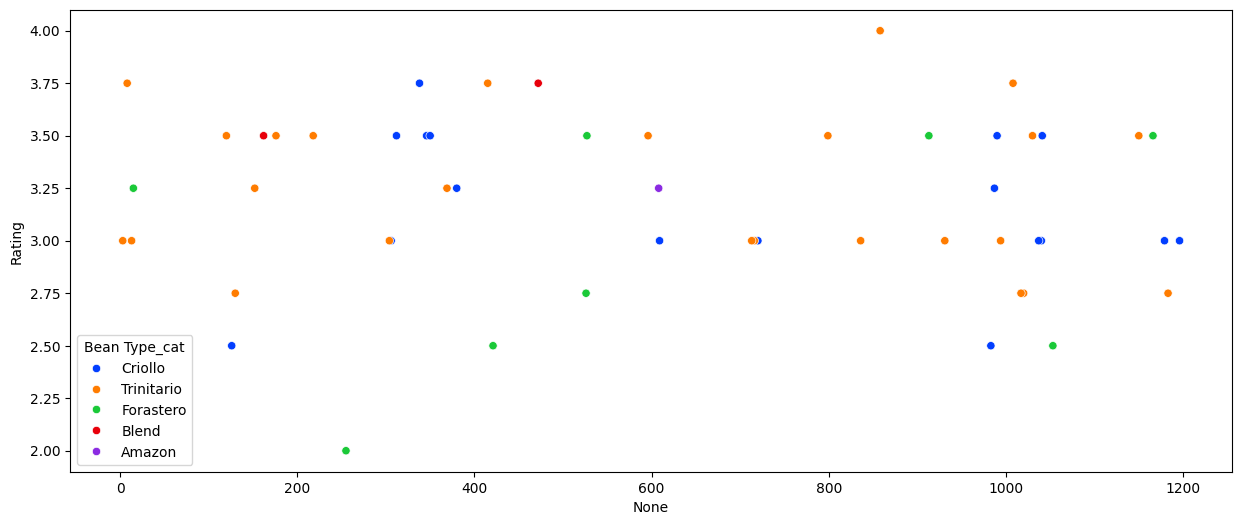

In [18]:
plt.figure(figsize=(15, 6))
XX=X_new.sample(100)
sns.scatterplot(data=XX, x=XX.index, y=y[XX.index], hue='Bean Type_cat', palette='bright');

#### Распределение целевой переменной

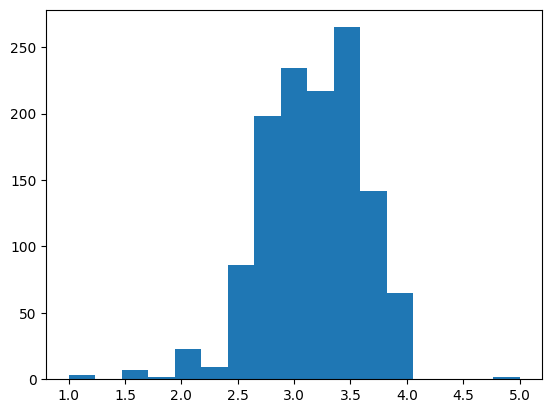

In [19]:
plt.hist(y, bins=17);

Близко к нормальному распределению. Ничего с этим делать не будем.

#### Обработка категориальных признаков

In [20]:
cat_cols = X_new.columns[X_new.dtypes == 'object']
num_cols = X_new.columns[X_new.dtypes != 'object']

Review


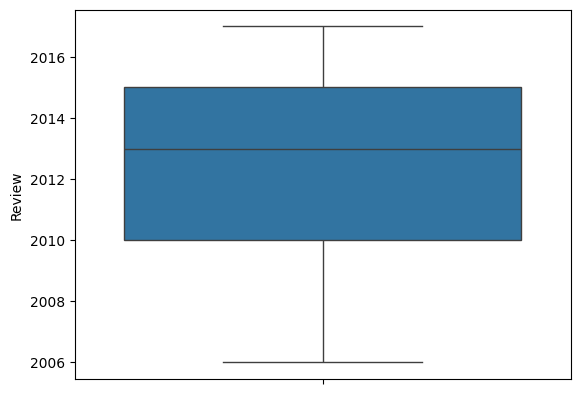

Rating


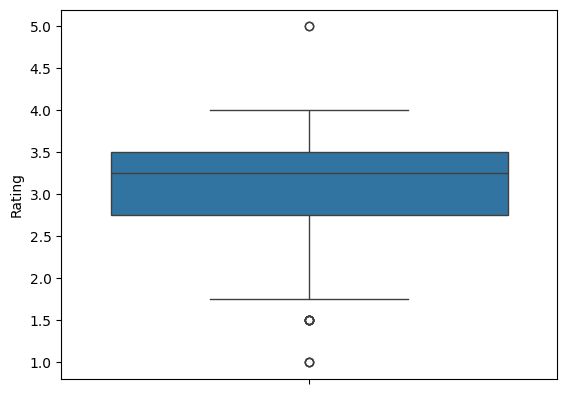

Cocoa Percent_numeric


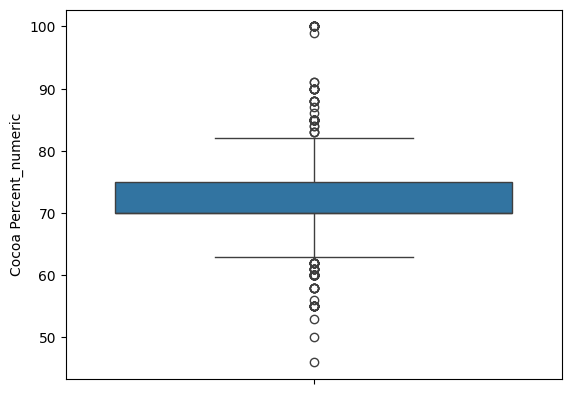

Cocoa Percent_numeric_binned


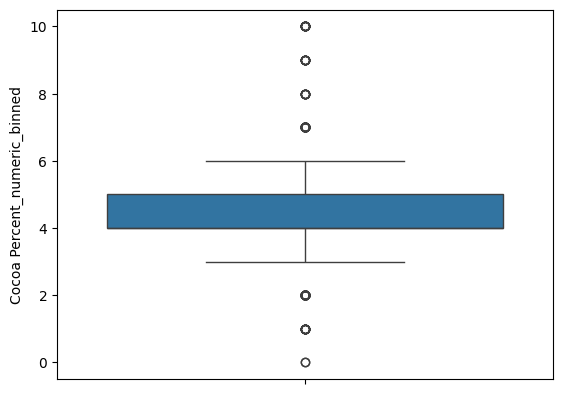

In [21]:
for col in num_cols:
    print(col)
    sns.boxplot(X_new[col])
    plt.show()

Даже экстремальные значения "процент какао" встречаются в жизни, поэтому оставляем как есть.

## Заполнение пропусков

In [22]:
X_new.isna().sum()

Company                           0
Review                            0
Company Location                  0
Rating                            0
Cocoa Percent_numeric             0
Specific Bean Origin_cat          0
Bean Type_cat                   628
Cocoa Percent_numeric_binned      0
dtype: int64

Заполнение пропусков в `Bean Type_cat`:
1. где возможно, заполнять модой по группировке по `Specific Bean Origin_cat`
2. остальное - значением `unknown`

In [23]:
# X_train_transformed['Bean Type_cat'] = X_train_transformed.groupby(['Broad Bean Origin_cat', 'Specific Bean Origin_cat'])['Bean Type_cat'].transform(
#     lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan)
# )

# X_new['Bean Type_cat'] = X_new.groupby(['Broad Bean Origin_cat'])['Bean Type_cat'].transform(
#     lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan)
# )

X_new['Bean Type_cat'] = X_new.groupby(['Specific Bean Origin_cat'])['Bean Type_cat'].transform(
    lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan)
)

X_new['Bean Type_cat'] = X_new['Bean Type_cat'].fillna('unknown')

In [24]:
X_new.isna().sum()

Company                         0
Review                          0
Company Location                0
Rating                          0
Cocoa Percent_numeric           0
Specific Bean Origin_cat        0
Bean Type_cat                   0
Cocoa Percent_numeric_binned    0
dtype: int64

## Обучение модели

Устанавливаем катбуст и обучаем его с гиперпараметрами по умолчанию на всех данных

In [25]:
X_new.drop(['Rating', 'Cocoa Percent_numeric'], axis=1, inplace=True)

In [26]:
X_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1253 entries, 0 to 1254
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Company                       1253 non-null   object 
 1   Review                        1253 non-null   int64  
 2   Company Location              1253 non-null   object 
 3   Specific Bean Origin_cat      1253 non-null   object 
 4   Bean Type_cat                 1253 non-null   object 
 5   Cocoa Percent_numeric_binned  1253 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 100.8+ KB


Обучаем CatBoostRegressor с гиперпараметрами по умолчанию на всех данных

In [27]:
from catboost import CatBoostRegressor
cat_features = [0, 2, 3, 4]
model = CatBoostRegressor(cat_features=cat_features, verbose=False)

In [227]:
model.fit(X_new, y)

In [228]:
model.score(X_new, y)

0.4932230268399286

In [231]:
print_score(model, X_train, y_train, X_test, y_test)

{'train': 0.49987447657163253, 'test': 0.47297869592858843}

In [30]:
# TODO: что можно сделать для улучшения модели:
# 1. Масштабирование признаков
# 2. Удаление выбросов
# 3. Подбор гиперпараметров

## Предсказание на тестовых данных

### Загрузка тестовых данных

In [31]:
test_df = pd.read_csv(TEST)

In [32]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Company               540 non-null    object
 1   Specific Bean Origin  540 non-null    object
 2   REF                   540 non-null    int64 
 3   Review                540 non-null    int64 
 4   Cocoa Percent         540 non-null    object
 5   Company Location      540 non-null    object
 6   Bean Type             540 non-null    object
 7   Broad Bean Origin     540 non-null    object
dtypes: int64(2), object(6)
memory usage: 33.9+ KB


### Обработка тестовых данных

In [33]:
X_test_transformed = clean_df(test_df.copy())

1:  (540, 9)
2:  (540, 10)
3:  (540, 11)
4:  (540, 12)
5:  (540, 7)


In [34]:
X_test_transformed['Cocoa Percent_numeric_binned'] = discretizer.transform(X_test_transformed[['Cocoa Percent_numeric']])

In [35]:
X_test_transformed.drop(['Broad Bean Origin_cat', 'Cocoa Percent_numeric'], axis=1, inplace=True)

In [36]:
X_test_transformed.isna().sum()

Company                           0
Review                            0
Company Location                  0
Specific Bean Origin_cat          0
Bean Type_cat                   259
Cocoa Percent_numeric_binned      0
dtype: int64

In [37]:
X_test_transformed['Bean Type_cat'] = X_test_transformed.groupby(['Specific Bean Origin_cat'])['Bean Type_cat'].transform(
    lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan)
)

X_test_transformed['Bean Type_cat'] = X_test_transformed['Bean Type_cat'].fillna('unknown')

In [38]:
X_test_transformed.isna().sum()

Company                         0
Review                          0
Company Location                0
Specific Bean Origin_cat        0
Bean Type_cat                   0
Cocoa Percent_numeric_binned    0
dtype: int64

In [39]:
X_test_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Company                       540 non-null    object 
 1   Review                        540 non-null    int64  
 2   Company Location              540 non-null    object 
 3   Specific Bean Origin_cat      540 non-null    object 
 4   Bean Type_cat                 540 non-null    object 
 5   Cocoa Percent_numeric_binned  540 non-null    float64
dtypes: float64(1), int64(1), object(4)
memory usage: 25.4+ KB


### Предсказание

In [40]:
pred = model.predict(X_test_transformed)

Функция для сохранения предсказания в файл в нужном формате и отправки на Kaggle

In [49]:
def save_and_submit(pred, model, test_df, SUBMISSION_NAME, PREFIX_TXT = "stepik-13.5", submit = False):
    test_df['id'] = np.arange(len(test_df))
    test_df['Rating'] = pred

    test_df[['id','Rating']].to_csv(f"{SUBMISSION_NAME}.csv", index=False)
    with open(f'model-{PREFIX_TXT}-{SUBMISSION_NAME}.pkl', 'wb') as f:
        pickle.dump(model, f)

    if submit:
        !kaggle competitions submit -c chocolate-rating-prediction-ai-edu -f {SUBMISSION_NAME}.csv -m "{SUBMISSION_NAME}"
        !kaggle competitions submissions -c chocolate-rating-prediction-ai-edu

In [52]:
save_and_submit(pred, model, test_df, "submission_4_copy3", submit = True)

100%|██████████████████████████████████████| 11.8k/11.8k [00:01<00:00, 11.3kB/s]
Successfully submitted to Chocolate rating prediction [Ai Edu]fileName                 date                 description         status    publicScore  privateScore  
-----------------------  -------------------  ------------------  --------  -----------  ------------  
submission_4_copy3.csv   2025-02-07 11:36:10  submission_4_copy3  complete  0.22163                    
submission_4_copy2.csv   2025-02-06 13:01:31  submission_4_copy2  complete  0.22163                    
submission_4_copy.csv    2025-02-05 22:41:57  submission_4_copy   complete  0.22207                    
submission_4.csv         2025-02-04 21:44:51                      complete  0.22163                    
submission_3.csv         2025-02-03 22:53:49                      complete  0.16383                    
submission_2.csv         2025-02-02 23:23:33                      complete  0.17017                    
baseline_submission.csv  

## Попытки улучшения

Для начала реализуем пайплайны и проверим их на самой просто линейной регрессии

In [204]:
from category_encoders.ordinal import OrdinalEncoder
from category_encoders.one_hot import OneHotEncoder
from category_encoders.target_encoder import TargetEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from pprint import pprint as pp
from sklearn.metrics import r2_score

In [185]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.25, random_state=42)

In [196]:
r2_scores = {}  # для сохранения r2_scores всех моделей

In [187]:
def print_score(p, X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame, y_test: pd.Series):
    res = {}
    res["train"] = p.score(X_train, y_train)
    res["test"] = p.score(X_test, y_test)
    return res


In [197]:
# Ориентируемся на первую модель.
# Дает 0.22163 на Kaggle

model.score(X_new, y)
r2_scores["model"] = print_score(model, X_train, y_train, X_test, y_test)
pp(r2_scores)

{'model': {'test': 0.47297869592858843, 'train': 0.49987447657163253}}


Очень плохо.

In [198]:
from sklearn.preprocessing import MinMaxScaler

p1 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols)),
    ('scaler_', StandardScaler()),
    ('model_', LinearRegression())
    ])

# по умолчанию smoothing = 10

p2 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols, smoothing=1)),
    ('scaler_', StandardScaler()),
    ('model_', LinearRegression())
    ])

p3 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols, smoothing=100)),
    ('scaler_', StandardScaler()),
    ('model_', LinearRegression())
    ])

p4 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols, smoothing=1)),
    ('scaler_', MinMaxScaler()),
    ('model_', LinearRegression())
    ])

p5 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols, smoothing=10)),
    ('scaler_', MinMaxScaler()),
    ('model_', LinearRegression())
    ])

p6 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols, smoothing=100)),
    ('scaler_', MinMaxScaler()),
    ('model_', LinearRegression())
    ])

p7 = Pipeline([
    ('encoder_',LeaveOneOutEncoder(cols=cat_cols)),
    ('scaler_', StandardScaler()),
    ('model_', LinearRegression())
    ])

p8 = Pipeline([
    ('encoder_',LeaveOneOutEncoder(cols=cat_cols)),
    ('scaler_', MinMaxScaler()),
    ('model_', LinearRegression())
    ])

In [199]:
for i,p in zip(range(1,9), [p1,p2,p3,p4,p5,p6,p7,p8]):
    p.fit(X_train, y_train)
    pred_ = p.predict(X_test)
    r2_scores[f"p{i}"] = print_score(p, X_train, y_train, X_test, y_test)

pp(r2_scores)

{'model': {'test': 0.47297869592858843, 'train': 0.49987447657163253},
 'p1': {'test': -0.013158653940478438, 'train': 0.612098504242313},
 'p2': {'test': -0.004615622820015597, 'train': 0.12382269065956364},
 'p3': {'test': -0.026735647384129813, 'train': 0.7205170248491082},
 'p4': {'test': -0.004615622820014709, 'train': 0.12382269065956286},
 'p5': {'test': -0.013158653940478215, 'train': 0.6120985042423128},
 'p6': {'test': -0.026735647384129813, 'train': 0.7205170248491082},
 'p7': {'test': 0.06367949166882036, 'train': 0.34331941191550974},
 'p8': {'test': 0.06367949166882092, 'train': 0.34331941191550963}}


Прорыва не случилось. Сменим модель на Случайное дерево.

In [200]:
p9 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols)),
    ('scaler_', StandardScaler()),
    ('model_', RandomForestRegressor(n_jobs=-1))
    ])

p10 = Pipeline([
    ('encoder_',LeaveOneOutEncoder(cols=cat_cols)),
    ('scaler_', StandardScaler()),
    ('model_', RandomForestRegressor(n_jobs=-1))
    ])

p11 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols)),
    ('scaler_', MinMaxScaler()),
    ('model_', RandomForestRegressor(n_jobs=-1))
    ])

p12 = Pipeline([
    ('encoder_',LeaveOneOutEncoder(cols=cat_cols)),
    ('scaler_', MinMaxScaler()),
    ('model_', RandomForestRegressor(n_jobs=-1))
    ])

p13 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols, smoothing=1)),
    ('scaler_', StandardScaler()),
    ('model_', RandomForestRegressor(n_jobs=-1))
    ])

In [202]:
for i,p in zip(range(9,14), [p9,p10,p11,p12,p13]):
    p.fit(X_train, y_train)
    pred_ = p.predict(X_test)
    r2_scores[f"p{i}"] = print_score(p, X_train, y_train, X_test, y_test)

pp(r2_scores)

{'model': {'test': 0.47297869592858843, 'train': 0.49987447657163253},
 'p1': {'test': -0.013158653940478438, 'train': 0.612098504242313},
 'p10': {'test': -0.019605051636775617, 'train': 0.16969376575796158},
 'p11': {'test': 0.024917267366840967, 'train': 0.9505771133737102},
 'p12': {'test': 0.00030745587896430226, 'train': 0.1635102069979063},
 'p13': {'test': 0.007547606989263267, 'train': 0.9379138544742707},
 'p2': {'test': -0.004615622820015597, 'train': 0.12382269065956364},
 'p3': {'test': -0.026735647384129813, 'train': 0.7205170248491082},
 'p4': {'test': -0.004615622820014709, 'train': 0.12382269065956286},
 'p5': {'test': -0.013158653940478215, 'train': 0.6120985042423128},
 'p6': {'test': -0.026735647384129813, 'train': 0.7205170248491082},
 'p7': {'test': 0.06367949166882036, 'train': 0.34331941191550974},
 'p8': {'test': 0.06367949166882092, 'train': 0.34331941191550963},
 'p9': {'test': 0.005232846420800907, 'train': 0.9507038739153184}}


## Улучшаем дальше

In [203]:
data_pipeline = Pipeline([
        ('encoder_',LeaveOneOutEncoder(cols=cat_cols)),
        ('scaler_', MinMaxScaler())
])

X_train_good = data_pipeline.fit_transform(X_train, y_train)
X_test_good = data_pipeline.transform(X_test)

In [208]:
import optuna

def objective(trial):

    param = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 1000),
        "max_features": trial.suggest_float("max_features", 0.1, 1.)
    }

    estimator = RandomForestRegressor(**param, verbose=False, n_jobs=-1)

    estimator.fit(X_train_good, y_train)
    _pred = estimator.predict(X_test_good)

    return  r2_score(y_test, _pred)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=15)
print(study.best_trial)

[I 2025-02-07 19:43:30,526] A new study created in memory with name: no-name-bdbba55c-ca98-4032-aa8d-13f4935b208a
[I 2025-02-07 19:43:31,011] Trial 0 finished with value: 0.01478193808371664 and parameters: {'n_estimators': 555, 'max_features': 0.6811481947204084}. Best is trial 0 with value: 0.01478193808371664.
[I 2025-02-07 19:43:31,724] Trial 1 finished with value: 0.016984720072778292 and parameters: {'n_estimators': 994, 'max_features': 0.6372317179890608}. Best is trial 1 with value: 0.016984720072778292.
[I 2025-02-07 19:43:31,924] Trial 2 finished with value: 0.005923709495888274 and parameters: {'n_estimators': 256, 'max_features': 0.1464667487248043}. Best is trial 1 with value: 0.016984720072778292.
[I 2025-02-07 19:43:31,975] Trial 3 finished with value: -0.007718567276540744 and parameters: {'n_estimators': 39, 'max_features': 0.8339573776850538}. Best is trial 1 with value: 0.016984720072778292.
[I 2025-02-07 19:43:32,162] Trial 4 finished with value: 0.01438277942374299

FrozenTrial(number=13, state=1, values=[0.01813235477276598], datetime_start=datetime.datetime(2025, 2, 7, 19, 43, 35, 464919), datetime_complete=datetime.datetime(2025, 2, 7, 19, 43, 35, 774807), params={'n_estimators': 421, 'max_features': 0.542425419338737}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=10, step=1), 'max_features': FloatDistribution(high=1.0, log=False, low=0.1, step=None)}, trial_id=13, value=None)


In [216]:
import optuna

def objective_cb(trial):

    param = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 1000),
        "max_depth": trial.suggest_int("max_depth", 2, 16),
    }

    estimator = CatBoostRegressor(**param, cat_features=cat_features, verbose=False)

    estimator.fit(X_train, y_train)
    _pred = estimator.predict(X_test)

    return r2_score(y_test, _pred)

study_cb = optuna.create_study(direction="maximize")
study_cb.optimize(objective_cb, n_trials=50)
print(study_cb.best_trial)

[I 2025-02-07 19:51:33,893] A new study created in memory with name: no-name-aef4f331-37f7-4871-b54f-c93ce583b90c


[I 2025-02-07 19:51:34,033] Trial 0 finished with value: -0.0673291467888093 and parameters: {'n_estimators': 47, 'max_depth': 10}. Best is trial 0 with value: -0.0673291467888093.
[I 2025-02-07 19:51:34,839] Trial 1 finished with value: 0.08551285043211432 and parameters: {'n_estimators': 604, 'max_depth': 7}. Best is trial 1 with value: 0.08551285043211432.
[I 2025-02-07 19:51:35,309] Trial 2 finished with value: 0.07727383325535031 and parameters: {'n_estimators': 202, 'max_depth': 10}. Best is trial 1 with value: 0.08551285043211432.
[I 2025-02-07 19:52:24,087] Trial 3 finished with value: 0.08481932271380721 and parameters: {'n_estimators': 756, 'max_depth': 16}. Best is trial 1 with value: 0.08551285043211432.
[I 2025-02-07 19:52:25,175] Trial 4 finished with value: 0.04107861422416892 and parameters: {'n_estimators': 470, 'max_depth': 10}. Best is trial 1 with value: 0.08551285043211432.
[I 2025-02-07 19:52:25,645] Trial 5 finished with value: 0.11634435122991726 and parameters:

FrozenTrial(number=39, state=1, values=[0.11733371423982197], datetime_start=datetime.datetime(2025, 2, 7, 19, 53, 38, 442788), datetime_complete=datetime.datetime(2025, 2, 7, 19, 53, 38, 915173), params={'n_estimators': 950, 'max_depth': 3}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=10, step=1), 'max_depth': IntDistribution(high=16, log=False, low=2, step=1)}, trial_id=39, value=None)


In [ ]:
model_cb2 = CatBoostRegressor(n_estimators=950, max_depth=3, cat_features=cat_features)

model_cb2.fit(X_train, y_train)
pred_cb2 = model.predict(X_test)

r2_scores["model_cb2"] = print_score(model_cb2, X_train, y_train, X_test, y_test)

Learning rate set to 0.042264
0:	learn: 0.4721326	total: 3.4ms	remaining: 3.23s
1:	learn: 0.4714586	total: 4.24ms	remaining: 2.01s
2:	learn: 0.4693551	total: 5.94ms	remaining: 1.87s
3:	learn: 0.4675730	total: 6.66ms	remaining: 1.57s
4:	learn: 0.4658699	total: 8.08ms	remaining: 1.53s
5:	learn: 0.4645312	total: 9.52ms	remaining: 1.5s
6:	learn: 0.4630650	total: 10.7ms	remaining: 1.44s
7:	learn: 0.4618533	total: 11ms	remaining: 1.3s
8:	learn: 0.4604482	total: 12ms	remaining: 1.25s
9:	learn: 0.4588978	total: 13.1ms	remaining: 1.23s
10:	learn: 0.4569805	total: 14.3ms	remaining: 1.22s
11:	learn: 0.4556368	total: 15.5ms	remaining: 1.21s
12:	learn: 0.4547202	total: 16ms	remaining: 1.15s
13:	learn: 0.4539321	total: 16.3ms	remaining: 1.09s
14:	learn: 0.4528620	total: 16.8ms	remaining: 1.05s
15:	learn: 0.4520470	total: 18ms	remaining: 1.05s
16:	learn: 0.4510708	total: 18.5ms	remaining: 1.01s
17:	learn: 0.4501559	total: 19.1ms	remaining: 988ms
18:	learn: 0.4491092	total: 20.2ms	remaining: 991ms
19:

In [248]:
model_cb = CatBoostRegressor(cat_features=cat_features)
model_cb.fit(X_train, y_train)
r2_scores["model_cb"] = print_score(model_cb, X_train, y_train, X_test, y_test)


Learning rate set to 0.040538
0:	learn: 0.4713333	total: 4.98ms	remaining: 4.98s
1:	learn: 0.4693270	total: 7.86ms	remaining: 3.92s
2:	learn: 0.4685417	total: 8.88ms	remaining: 2.95s
3:	learn: 0.4665478	total: 10.7ms	remaining: 2.66s
4:	learn: 0.4643240	total: 12.5ms	remaining: 2.49s
5:	learn: 0.4613422	total: 13.9ms	remaining: 2.3s
6:	learn: 0.4592090	total: 15.7ms	remaining: 2.23s
7:	learn: 0.4571313	total: 21ms	remaining: 2.6s
8:	learn: 0.4551123	total: 26.1ms	remaining: 2.87s
9:	learn: 0.4533614	total: 32.3ms	remaining: 3.19s
10:	learn: 0.4512405	total: 36.4ms	remaining: 3.27s
11:	learn: 0.4494154	total: 39.3ms	remaining: 3.24s
12:	learn: 0.4481357	total: 44.8ms	remaining: 3.4s
13:	learn: 0.4465169	total: 48.3ms	remaining: 3.4s
14:	learn: 0.4449594	total: 51.3ms	remaining: 3.37s
15:	learn: 0.4439078	total: 53.1ms	remaining: 3.26s
16:	learn: 0.4426066	total: 58.5ms	remaining: 3.38s
17:	learn: 0.4415968	total: 62ms	remaining: 3.38s
18:	learn: 0.4404282	total: 65.8ms	remaining: 3.4s
1

In [250]:
model_cb2_2 = CatBoostRegressor(n_estimators=950, max_depth=3, cat_features=cat_features)
model_cb2_2.fit(X_new, y)
r2_scores["model_cb2_2"] = print_score(model_cb2_2, X_train, y_train, X_test, y_test)

Learning rate set to 0.044235
0:	learn: 0.4766096	total: 2.45ms	remaining: 2.33s
1:	learn: 0.4749378	total: 4.98ms	remaining: 2.36s
2:	learn: 0.4727292	total: 6.66ms	remaining: 2.1s
3:	learn: 0.4708696	total: 7.8ms	remaining: 1.84s
4:	learn: 0.4691218	total: 8.5ms	remaining: 1.61s
5:	learn: 0.4671956	total: 9.26ms	remaining: 1.46s
6:	learn: 0.4652359	total: 10.1ms	remaining: 1.36s
7:	learn: 0.4637275	total: 10.7ms	remaining: 1.26s
8:	learn: 0.4623879	total: 11.3ms	remaining: 1.18s
9:	learn: 0.4608247	total: 12.6ms	remaining: 1.19s
10:	learn: 0.4595658	total: 13.1ms	remaining: 1.12s
11:	learn: 0.4584578	total: 13.6ms	remaining: 1.06s
12:	learn: 0.4571898	total: 14ms	remaining: 1.01s
13:	learn: 0.4560305	total: 14.4ms	remaining: 963ms
14:	learn: 0.4549544	total: 14.9ms	remaining: 927ms
15:	learn: 0.4540860	total: 15.2ms	remaining: 889ms
16:	learn: 0.4529886	total: 15.6ms	remaining: 857ms
17:	learn: 0.4522590	total: 16ms	remaining: 830ms
18:	learn: 0.4514067	total: 16.3ms	remaining: 801ms

In [260]:
pp(r2_scores)


{'model': {'test': 0.47297869592858843, 'train': 0.49987447657163253},
 'model_cb': {'test': 0.0927132772872663, 'train': 0.5282661035083401},
 'model_cb2': {'test': 0.11733371423982197, 'train': 0.4500799346346961},
 'model_cb2_2': {'test': 0.4136885699911872, 'train': 0.47689971887054594},
 'p1': {'test': -0.013158653940478438, 'train': 0.612098504242313},
 'p10': {'test': -0.019605051636775617, 'train': 0.16969376575796158},
 'p11': {'test': 0.024917267366840967, 'train': 0.9505771133737102},
 'p12': {'test': 0.00030745587896430226, 'train': 0.1635102069979063},
 'p13': {'test': 0.007547606989263267, 'train': 0.9379138544742707},
 'p2': {'test': -0.004615622820015597, 'train': 0.12382269065956364},
 'p3': {'test': -0.026735647384129813, 'train': 0.7205170248491082},
 'p4': {'test': -0.004615622820014709, 'train': 0.12382269065956286},
 'p5': {'test': -0.013158653940478215, 'train': 0.6120985042423128},
 'p6': {'test': -0.026735647384129813, 'train': 0.7205170248491082},
 'p7': {'tes

In [257]:
pred = model_cb2_2.predict(X_test_transformed)

In [258]:
pred.shape

(540,)

In [253]:
!kaggle competitions submissions -c chocolate-rating-prediction-ai-edu

21755.97s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


fileName                 date                 description         status    publicScore  privateScore  
-----------------------  -------------------  ------------------  --------  -----------  ------------  
submission_5.csv         2025-02-07 11:38:54  submission_5        complete  0.05796                    
submission_4_copy3.csv   2025-02-07 11:36:10  submission_4_copy3  complete  0.22163                    
submission_4_copy2.csv   2025-02-06 13:01:31  submission_4_copy2  complete  0.22163                    
submission_4_copy.csv    2025-02-05 22:41:57  submission_4_copy   complete  0.22207                    
submission_4.csv         2025-02-04 21:44:51                      complete  0.22163                    
submission_3.csv         2025-02-03 22:53:49                      complete  0.16383                    
submission_2.csv         2025-02-02 23:23:33                      complete  0.17017                    
baseline_submission.csv  2025-02-02 22:23:33  Baseline          

In [259]:
save_and_submit(pred, model_cb2_2, test_df, "submission_6_cb2_2", submit = True)

21850.87s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


100%|██████████████████████████████████████| 11.8k/11.8k [00:00<00:00, 24.4kB/s]
Successfully submitted to Chocolate rating prediction [Ai Edu]

21858.46s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


fileName                 date                 description         status    publicScore  privateScore  
-----------------------  -------------------  ------------------  --------  -----------  ------------  
submission_6_cb2_2.csv   2025-02-07 17:23:51  submission_6_cb2_2  complete  0.21291                    
submission_5.csv         2025-02-07 11:38:54  submission_5        complete  0.05796                    
submission_4_copy3.csv   2025-02-07 11:36:10  submission_4_copy3  complete  0.22163                    
submission_4_copy2.csv   2025-02-06 13:01:31  submission_4_copy2  complete  0.22163                    
submission_4_copy.csv    2025-02-05 22:41:57  submission_4_copy   complete  0.22207                    
submission_4.csv         2025-02-04 21:44:51                      complete  0.22163                    
submission_3.csv         2025-02-03 22:53:49                      complete  0.16383                    
submission_2.csv         2025-02-02 23:23:33                    